# Population-Level Vaccination and Its Dynamic Link to Mortality Rate Through Lag-Adjusted CFR
**By Muhammad Fuad Dhiya Ulhaq**

## 1. Importing Library and Dataset

### 1.1 Importing Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from datetime import datetime

### 1.2 Data Importing: Covid-19 and Vaccination Dataset

In [2]:
# Importing Data from Repository
path1 = 'data/covid_data/covid_19_indonesia_time_series_all.csv'
path2 = 'data/vaccination_data/country_vaccinations.csv'

# Reading Data using Pandas
df_covid = pd.read_csv(path1)
df_vaccination = pd.read_csv(path2)

### 1.3 Data Cleaning: Covid-19

In [3]:
# Creating the Specific Dataframe (Covid Data)
df_id = df_covid[df_covid['Location'] == 'Indonesia'][['Date', 'New Cases', 'New Deaths']]
df_id

# Changing Date Types to Datetime
df_id['Date'] = pd.to_datetime(df_id['Date'])

### 1.4 Data Cleaning: Vaccination

In [4]:
df_id_vaccination = df_vaccination[df_vaccination['country'] == 'Indonesia'][['date', 'people_fully_vaccinated_per_hundred', 'daily_vaccinations_per_million']]
df_id_vaccination.columns
df_id_vaccination['date'] = pd.to_datetime(df_id_vaccination['date'])

In [5]:
# print(f'This is xxx:{df_.head}')
print(df_id.info())
print('-------------------')
print('-------------------')
print('-------------------')
print(df_id_vaccination.info())

<class 'pandas.core.frame.DataFrame'>
Index: 929 entries, 2 to 31821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        929 non-null    datetime64[ns]
 1   New Cases   929 non-null    int64         
 2   New Deaths  929 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 29.0 KB
None
-------------------
-------------------
-------------------
<class 'pandas.core.frame.DataFrame'>
Index: 442 entries, 35811 to 36252
Data columns (total 3 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 442 non-null    datetime64[ns]
 1   people_fully_vaccinated_per_hundred  417 non-null    float64       
 2   daily_vaccinations_per_million       441 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 13.8 KB
None


## 2. Data Manipulation
- Why manipulate? Covid-19 Vaccine have lagged effect of couple of weeks to the body to develop maximum levels of immunity. Hence we need to move the date of vaccination attempt to two weeks prior.

### How do we manipulate the data?
**Data 1 - People Fully Vaccinated**  : We will simply move this data to two weeks prior by creating a new column.

### 2.1 Treating the Null Data
We treat the null data by filling the data using before or after existing data so it will have smooth graph.

In [6]:
# Treating the Null Using Data Before or After
df_id_vaccination['people_fully_vaccinated_per_hundred'] = df_id_vaccination['people_fully_vaccinated_per_hundred'].fillna(method='ffill')
df_id_vaccination['people_fully_vaccinated_per_hundred'] = df_id_vaccination['people_fully_vaccinated_per_hundred'].fillna(method='bfill')

# Checking Existence of Null Data
df_id_vaccination.isnull().sum()

/tmp/ipykernel_2013/4141505115.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_id_vaccination['people_fully_vaccinated_per_hundred'] = df_id_vaccination['people_fully_vaccinated_per_hundred'].fillna(method='ffill')
/tmp/ipykernel_2013/4141505115.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_id_vaccination['people_fully_vaccinated_per_hundred'] = df_id_vaccination['people_fully_vaccinated_per_hundred'].fillna(method='bfill')


date                                   0
people_fully_vaccinated_per_hundred    0
daily_vaccinations_per_million         1
dtype: int64

### 2.2 Manipulating the Data (see description)

In [7]:
# Data 1 - People Fully Vaccinated - Manipulation
df_id_vaccination['vaccinated_cumulative_lagged'] = df_id_vaccination['people_fully_vaccinated_per_hundred'].shift(14)

### 2.3 Merging Dataframe: Covid-19 and Vaccination Dataset

In [8]:
# Preparing to Merge both Data Frame
df_id_vaccination.rename(columns={'date':'Date'}, inplace=True)

df_id_vaccination_temporary = df_id_vaccination[['Date', 'vaccinated_cumulative_lagged']]

# New Merged Dataframe
df_merged = pd.merge(df_id, df_id_vaccination_temporary, on='Date', how='left')

## 3. Visualizing Merged Data

In [9]:
# Setting 'date' as the index
df_merged.set_index('Date', inplace=True)

### Graph 1: Comparing the Magnitude of New Cases and New Deaths

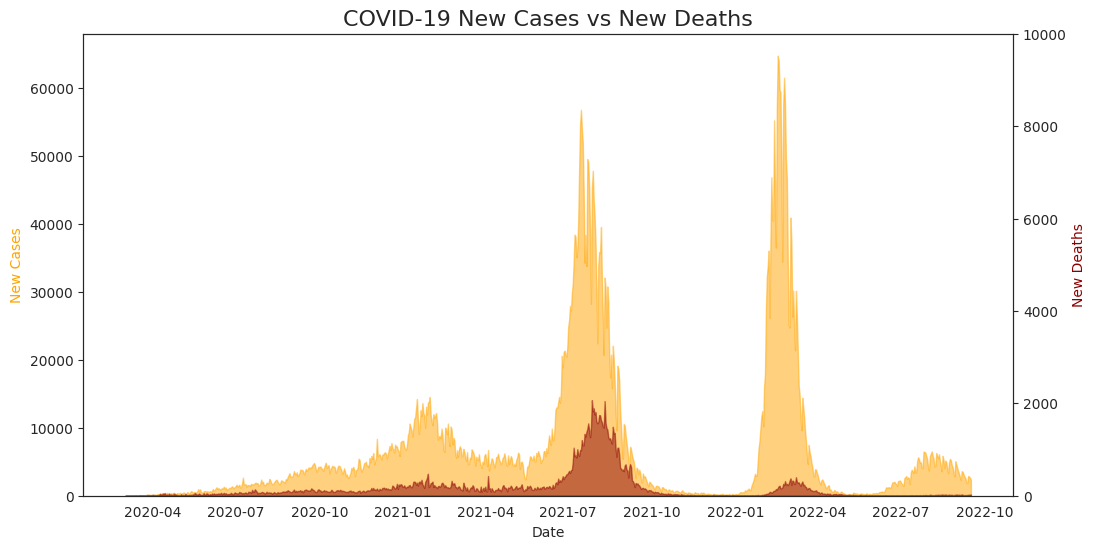

In [18]:
sns.set_style("white")  # remove seaborn default grids

fig, ax1 = plt.subplots(figsize=(12,6))

#  Plot New Cases (left y-axis, orange)
sns.lineplot(x=df_merged.index, y=df_merged['New Cases'], ax=ax1, color="orange", linewidth=0)
ax1.fill_between(df_merged.index, df_merged['New Cases'], color="orange", alpha=0.5)
ax1.set_ylabel("New Cases", color="orange")
ax1.set_ylim(bottom=0)

# Plot New Deaths (right y-axis, dark red)
ax2 = ax1.twinx()
sns.lineplot(x=df_merged.index, y=df_merged['New Deaths'], ax=ax2, color="darkred", linewidth=0)
ax2.fill_between(df_merged.index, df_merged['New Deaths'], color="darkred", alpha=0.5)
ax2.set_ylabel("New Deaths", color="darkred")
ax2.set_ylim(bottom=0, top=10000)

# Remove grids
ax1.grid(False)  
ax2.grid(False)

plt.title("COVID-19 New Cases vs New Deaths", fontsize=16)
plt.show()


**Interpretation** : This graph plots daily new COVID-19 cases (orange area, left axis) against new deaths (dark red, right axis) from 2020 through mid-2022 in Indonesia. It clearly visualizes two major pandemic waves: the first, around July 2021, shows a catastrophic spike in both cases and deaths, with fatalities reaching their highest point. The second wave, in early 2022, shows a peak in new cases that is even higher than the first, but the corresponding peak in new deaths is dramatically lower. This illustrates a significant change in the severity of the pandemic over time, with the later wave being substantially less deadly than the first.

### Graph 2: Percentage of Total Population Vaccinated to Deaths Relationship

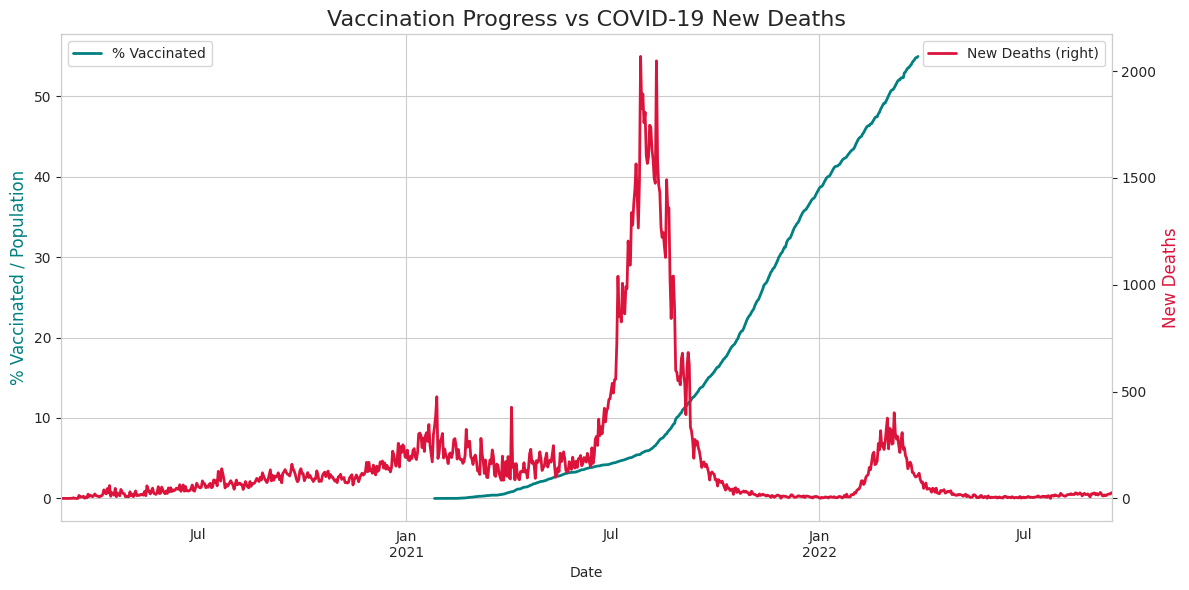

In [17]:
# Use a clean style
sns.set_style("whitegrid")
plt.figure(figsize=(12,6))

# Plot vaccinated cumulative (left y-axis)
ax = df_merged['vaccinated_cumulative_lagged'].plot(
    legend=True,
    ax=None,
    color="teal",
    linewidth=2,
    label="% Vaccinated"
)

# Plot new deaths (right y-axis)
df_merged['New Deaths'].plot(
    ax=ax,
    secondary_y=True,
    style='-',
    color="crimson",
    linewidth=2,
    legend=True,
    label="New Deaths"
)

# Label axes
ax.set_ylabel("% Vaccinated / Population", color="teal", fontsize=12)
ax.right_ax.set_ylabel("New Deaths", color="crimson", fontsize=12)

# Title & layout
plt.title("Vaccination Progress vs COVID-19 New Deaths", fontsize=16)
ax.legend(loc="upper left")
ax.right_ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

**Interpretation** : This dual-axis graph compares Indonesia's cumulative vaccination progress (blue line, left axis) with the daily number of new COVID-19 deaths (orange line, right axis). The most striking feature is the catastrophic spike in deaths in mid-2021, which occurred when the vaccination level was still below 10% of the population. As the vaccination rate steadily increased from late 2021 into 2022, the number of daily deaths dropped dramatically and remained at a much lower level. This visual evidence strongly suggests an inverse correlation, where the widespread rollout of vaccines was followed by a sustained reduction in COVID-19 fatalities.

## 4. Comparing Vaccinated Population and Death-Cases Ratio

### 4.1 Constructing The Weekly Dataset

In [12]:
# Create a duplicate DataFrame and find the valid date range
df_analysis = df_merged.copy()
begin_date = df_analysis['vaccinated_cumulative_lagged'].first_valid_index()
last_date = df_analysis['vaccinated_cumulative_lagged'].last_valid_index()

# Cut the new DataFrame to only include the valid range
df_analysis = df_analysis.loc[begin_date:last_date]

# Lag the 'New Cases' data by 14 days
df_analysis['New Cases_lagged_14d'] = df_analysis['New Cases'].shift(14)

# Resample the data to 1-week periods
weekly_sums = df_analysis[['New Deaths', 'New Cases_lagged_14d']].resample('W').sum()
weekly_vax_mean = df_analysis['vaccinated_cumulative_lagged'].resample('W').mean()

# Create the new bi-weekly DataFrame
df_weekly = pd.DataFrame()
df_weekly['lag_adjusted_cfr'] = (weekly_sums['New Deaths'] / weekly_sums['New Cases_lagged_14d']) * 100
df_weekly['avg_vaccination_level'] = weekly_vax_mean

# Clean up the final result
df_weekly.replace([np.inf, -np.inf], np.nan, inplace=True)
df_weekly.dropna(inplace=True)

# Choosing Stable Dataperiod
df_weekly = df_weekly[df_weekly['avg_vaccination_level'] > 3]

**Note** : The final step considers only populations with an average vaccination level exceeding 3%. This threshold is applied to minimize noise arising from the lag-adjusted case fatality ratio when vaccination coverage is below 3% (as illustrated in Graph 2), which could otherwise reduce the model’s performance.

### 4.2 Regression Plotting

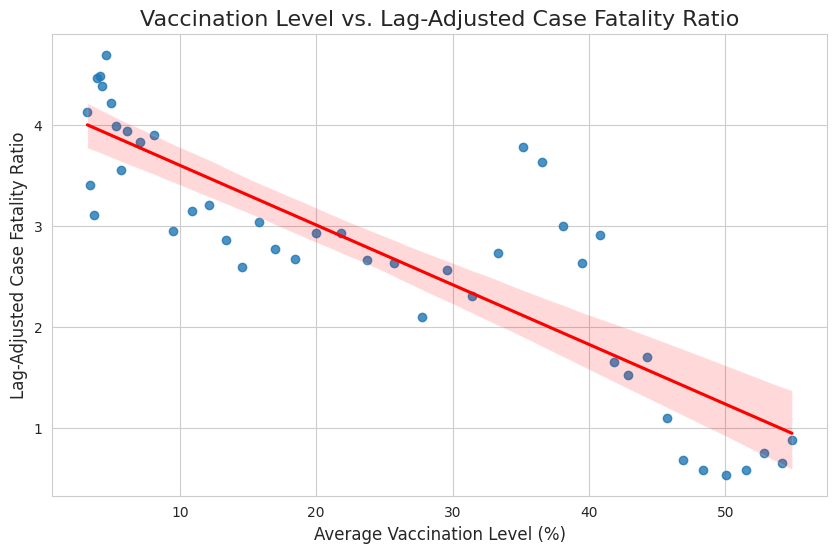

In [13]:
# Create the scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='avg_vaccination_level', 
            y='lag_adjusted_cfr', 
            data=df_weekly, 
            line_kws={"color": "red"})

# Add titles and labels
plt.title('Vaccination Level vs. Lag-Adjusted Case Fatality Ratio', fontsize=16)
plt.xlabel('Average Vaccination Level (%)', fontsize=12)
plt.ylabel('Lag-Adjusted Case Fatality Ratio', fontsize=12)
plt.grid(True)
plt.show()

**Interpretation** : This scatter plot illustrates a strong negative correlation between the average vaccination level and the lag-adjusted case fatality rate. As the percentage of the vaccinated population on the x-axis increases, the case fatality rate on the y-axis clearly trends downwards. This inverse relationship is confirmed by the red line of best fit, which slopes negatively across the data points, suggesting that higher vaccination levels are associated with a lower death rate from COVID-19.

## 5. Quantitative Analysis

### 5.1 Correlation

In [15]:
# Showing statistical correlation between variables
df_weekly.corr()

,lag_adjusted_cfr,avg_vaccination_level
lag_adjusted_cfr,1.000000,-0.866093
avg_vaccination_level,-0.866093,1.000000


**Interpretation** : This correlation matrix reveals a strong negative linear relationship between the average vaccination level and the lag-adjusted case fatality rate. The correlation coefficient of -0.866 indicates that as one variable increases, the other systematically decreases. 

### 5.2 OLS Regression Result

In [16]:
# Assigning dependent variable to y and independent variable to X
y = df_weekly['lag_adjusted_cfr']
X1 = df_weekly['avg_vaccination_level']

# Initiating the OLS Regression
X1 = sm.add_constant(X1)
model = sm.OLS(y, X1).fit()
print(model.summary()) 

                            OLS Regression Results                            
Dep. Variable:       lag_adjusted_cfr   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     129.1
Date:                Fri, 29 Aug 2025   Prob (F-statistic):           1.56e-14
Time:                        11:34:32   Log-Likelihood:                -40.262
No. Observations:                  45   AIC:                             84.52
Df Residuals:                      43   BIC:                             88.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.18

**Interpretation** : This OLS regression result shows a strong and statistically significant negative relationship between the vaccination level and the case fatality rate. The model has a good fit, explaining 75% of the variance in the lag-adjusted case fatality rate (R-squared = 0.750). The coefficient for avg_vaccination_level is -0.0590, which means that for every one-percentage-point increase in the average vaccination level, the case fatality rate is predicted to decrease by 0.059. This effect is highly significant, as shown by the p-value of 0.000, confirming the relationship is not due to random chance.